# SARS-CoV-2 Spike Protein Multiple Alignment





Severe acute respiratory syndrome coronavirus 2, or SARS-CoV-2, is responsible for the COVID-19 pandemic. The outbreak of the COVID-19 has brought together the global genomic research community to focus on understanding the virus. However, as scientists curate the virus genome and develop vaccines at an unprecedented speed, evidence of the SARS-CoV-2 evolution has been characterized by the emergence of sets of mutations that could potentially increase transmissibility or cause more severe disease. The Center of Disease Control and Prevention (CDC) has published a [SARS-CoV-2 Variant Classifications and Definitions](https://www.cdc.gov/coronavirus/2019-ncov/variants/variant-info.html) that categorizes the viral variants into three categories.


In this notebook, we will perform multiple protein alignment on the [spike protein](https://www.ncbi.nlm.nih.gov/gene/43740568) of different variants of SARS-CoV-2. The S surface glycoprotein is found on the outside of the virus particle and gives coronavirus viruses their crown-like appearance. It mediates attachment of the virus particle and entry into the host cell. As a result, S protein is an important target for vaccine development, antibody therapies and diagnostic antigen-based tests.

In [ ]:
#@title Install prerequisite this will take a while
# Install prerequisite, no need to run this if you are running the notebook from
# your laptop and you already install the packages in Anaconda 

!pip install biopython
!pip install ipytree
!pip install scikit-allel
!pip install zarr

# install mafft commandline
!wget https://mafft.cbrc.jp/alignment/software/mafft_7.471-1_amd64.deb
!sudo dpkg -i mafft_7.471-1_amd64.deb

In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set up data folder
from pathlib import Path

DATA = Path("/content/drive/My Drive/2022 ECBM E4060/data/")


### Load spike protein sequences

You can download all the spike protein sequences that have ever been submitted to NCBI as a data package from the [NCBI Datasets](https://www.ncbi.nlm.nih.gov/datasets/coronavirus/proteins/) website. We will be focusing on the following sequences for our analysis.

In [ ]:
seq_id_of_interest = [
    'QRN78347.1',
    'QRX39425.1',
    'QUD52764.1',
    'QWE88920.1',
    'UFO69279.1',
    'UOZ45804.1',
    'UTM82166.1',
    'YP_009724390.1',
]

Note the `YP_009724390.1` sequence is what we call a **reference sequence**. It is the base sequence we used to refer to all the mutations in the genome. For example, if we say a new virus genome has an `N501Y` mutation in its spike protein, it means that the virus has a `Y`(Tyrosine) at its 501st amino acid instead of an `N`(Asparagine), compared to the reference genome sequence.

We fetch these 8 sequences from NCBI, save them into a fasta file so we can perform multiple sequence alignment later.

In [ ]:
#==============================================================================
# Fetches the 8 sequences of interest of S protein and 
# saves them in a fasta file
#==============================================================================

from Bio import Entrez
Entrez.email = "ta2642@columbia.edu"

#fetch 
handle = Entrez.efetch(db="protein", id=seq_id_of_interest, rettype="fasta")

#save the sequences as a fasta file
fasta_file = "spike_protein_seqs.fasta"

with open(fasta_file, "w") as fo:
    fo.write(handle.read())



In [ ]:
#We can take a look at the saved fasta file by executing the shell command:

!cat spike_protein_seqs.fasta

>QRN78347.1 surface glycoprotein [Severe acute respiratory syndrome coronavirus 2]
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHV
SGTNGTKRFANPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPF
LGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPI
NLVRGLPQGFSALEPLVDLPIGINITRFQTLHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENG
TITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAW
NRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNY
KLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQ
SYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQ
QFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTW
RVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGVEN
SVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVE
QDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGD
IAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNG

In [ ]:
from Bio import SeqIO

In [ ]:
record = SeqIO.parse(open(fasta_file, 'r'),"fasta") #tell it's a fasta file, gives sequence objects
for seq in record:
    print("ID: {}, Length: {}".format(seq.id, len(seq)))

ID: QRN78347.1, Length: 1270
ID: QRX39425.1, Length: 1273
ID: QUD52764.1, Length: 1271
ID: QWE88920.1, Length: 1270
ID: UFO69279.1, Length: 1270
ID: UOZ45804.1, Length: 1268
ID: UTM82166.1, Length: 1270
ID: YP_009724390.1, Length: 1273


### Answer the following questions 

#### ** When we look into the sequence information of SARS-CoV-2 on [NCBI](https://www.ncbi.nlm.nih.gov/nuccore/NC_045512), we'll notice that its first line is:**

```
LOCUS       NC_045512              29903 bp ss-RNA     linear   VRL 18-JUL-2020
```




ss-RNA means single stranded RNA.
DNA is double stranded, whereas RNA is usually single-stranded. But it can form complex 3-D structure.

Source- Took Molecular Biology course previously. 

### Perform multiple sequence alignment

Now we have the sequences, let's run multiple sequence alignment. Recent publications have been using [`MAFFT`](https://mafft.cbrc.jp/alignment/server/) for aligning SARS-CoV-2 genome sequences. Here we will use `MAFFT` to perform multiple sequence alignment on S protein sequences. Similar to other multiple alignment algorithms, there is a `biopython` commandline wrapper for us to run easily: [`MafftCommandline`](https://biopython.org/docs/1.75/api/Bio.Align.Applications.html#Bio.Align.Applications.MafftCommandline) under `Bio.Align.Applications`. 

In [ ]:
#============================================================================
# Performs multiple sequence alignment using MafftCommandline class and 
# writes the alignment result to another fasta file
#============================================================================

from Bio.Align.Applications import MafftCommandline
mafft_cline = MafftCommandline(input=fasta_file)


In [ ]:
stdout, sterr = mafft_cline()

with open("align_spike_protein_seqs.fasta", "w") as handle:
    handle.write(stdout)

from Bio import AlignIO
align = AlignIO.read("align_spike_protein_seqs.fasta", "fasta")

aln_file = "align_spike_protein_seqs.fasta"

In [ ]:
print(align)

Alignment with 8 rows and 1275 columns
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT QRN78347.1
MFVFLVLLPLVSSQCVNFTNRTQLPSAYTNSFTRGVYYPDKVFR...HYT QRX39425.1
MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFR...HYT QUD52764.1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT QWE88920.1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT UFO69279.1
MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFR...HYT UOZ45804.1
MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFR...HYT UTM82166.1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT YP_009724390.1


With the alignment done, we can construct a [phylogenetic tree](https://en.wikipedia.org/wiki/Phylogenetic_tree) to quantify and visualize the genomic evolution of the virus taken from different locations. You can follow the document of [biopython's Phylo module](https://biopython.org/wiki/Phylo). 

First we will need to use the [`DistanceCalculator`](https://biopython.org/docs/1.75/api/Bio.Phylo.TreeConstruction.html#Bio.Phylo.TreeConstruction.DistanceCalculator) to generate distance matrix. As `MAFFT` by default uses `BLOSUM62` as the scoring matrix, we will need to set the `model` parameter of the `DistanceCalculator` class to `blosum62`.

Once we generate the distance matrix using `DistanceCalculator`, we will build the phylogenetic tree using the [UPGMA](https://en.wikipedia.org/wiki/UPGMA) method, which can be called through the [`DistanceTreeConstructor`](https://biopython.org/docs/1.75/api/Bio.Phylo.TreeConstruction.html#Bio.Phylo.TreeConstruction.DistanceTreeConstructor) class. We then draw your phylogenetic tree to visualize your result like we did in the class.


In [ ]:
#============================================================================
# Generate distance matrix using DistanceCalculator with `blosum62` as the
# scoring matrix, then construct a phylogenetic tree using
# DistanceTreeConstructor using UPGMA method
#============================================================================

In [ ]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

calculator = DistanceCalculator('blosum62') #distance calculator to calculate distance
dm = calculator.get_distance(align) #provide alignment



In [ ]:
#distance tree constructor
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm) #builds upgma tree from distance matrix

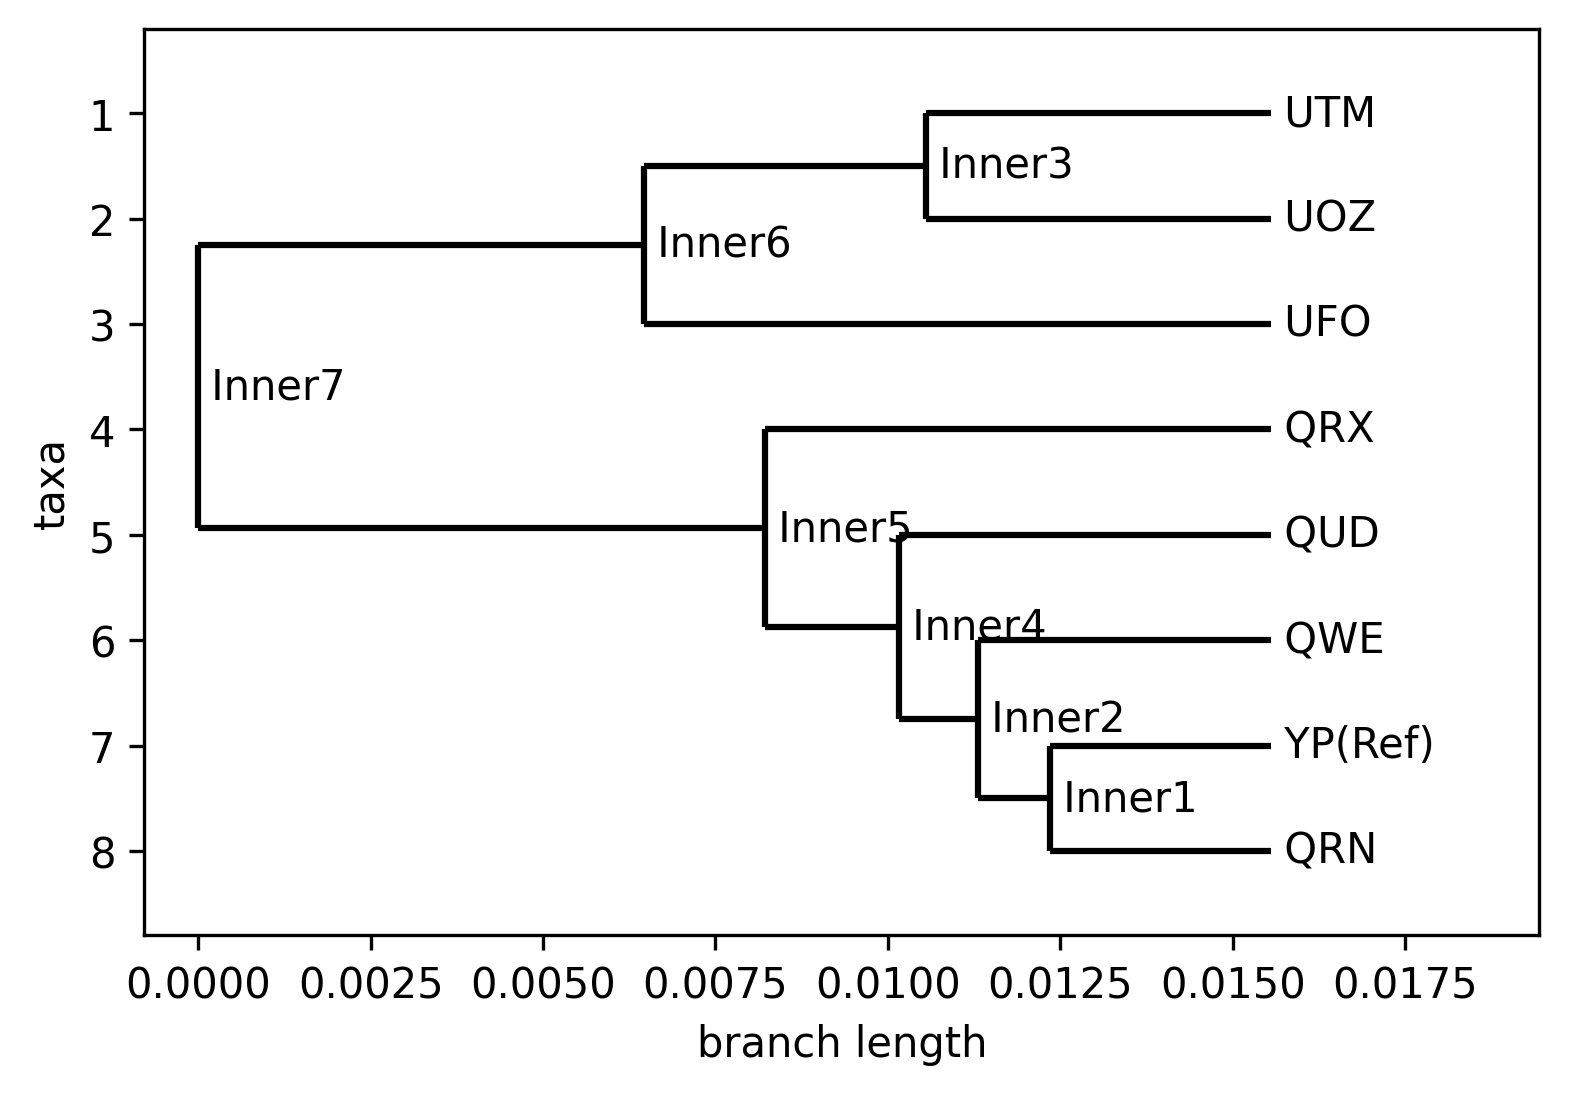

In [ ]:
#============================================================================
# Draw your phylogenetic tree
#============================================================================import matplotlib.pyplot as plt
from Bio import Phylo

# Let's annote each sequence by the virus subtype
virus_subtype_mapping = {
    'QRN78347.1': "QRN",
    'QRX39425.1': "QRX",
    'QUD52764.1': "QUD",
    'QWE88920.1': "QWE",
    'UFO69279.1': "UFO",
    'UOZ45804.1': "UOZ",
    'UTM82166.1': "UTM",
    'YP_009724390.1': "YP(Ref)",
    
}
fig, ax = plt.subplots(dpi=300)
Phylo.draw(tree, axes=ax,
           label_func=lambda n: virus_subtype_mapping[str(n)]
                                if str(n) in virus_subtype_mapping else str(n))

## From the phylogenetic tree we created on the sequences of interest, if we use a branch length cutoff of 0.005, we see 4 clusters



We see 4 clusters
- QUD, QWE, YP, QRN in one cluster
- QRX in one cluster
- UFO in one cluster
- UTM and UOZ in one cluster

### Assign variant sequence identities

Based on the alignment, using the reference sequence `YP_009724390.1` as the reference sequence, we can identify all mutations in spike proteins in the other 7 sequences. This can be done similarly to what we did for influenza hemagglutinin sequences in class.

Once we identify the mutations for each sequence in the spike protein, you can assign their variant identity (e.g. alpha, delta, omicron) based on the signature given in the following plot from ![Viralzon](https://viralzone.expasy.org/9556):

![](https://viralzone.expasy.org/resources/Variants_graph.svg)

In [ ]:
#============================================================================
# Identify mutations in each sequence compared to YP_009724390.1, and assign
# variant identity based on the figure in viralzone above
#============================================================================


In [ ]:
#we can index the alignment result into a `pandas` `DataFrame` 
import pandas as pd

# Let's read the alignment file again
aln = AlignIO.read(open(aln_file), 'fasta')
align_df = pd.DataFrame(dict([(virus_subtype_mapping[rec.name], list(rec.seq))
                              for rec in aln]))

In [ ]:
align_df

,QRN,QRX,QUD,QWE,UFO,UOZ,UTM,YP(Ref)
0,M,M,M,M,M,M,M,M
1,F,F,F,F,F,F,F,F
2,V,V,V,V,V,V,V,V
3,F,F,F,F,F,F,F,F
4,L,L,L,L,L,L,L,L
...,...,...,...,...,...,...,...,...
1270,K,K,K,K,K,K,K,K
1271,L,L,L,L,L,L,L,L
1272,H,H,H,H,H,H,H,H
1273,Y,Y,Y,Y,Y,Y,Y,Y


In [ ]:
# identify reference index using YP
aa_index = (align_df["YP(Ref)"] != "-").cumsum() #the length of ref genome
#counts the number of distince elements along axis 1
aa_count = align_df.apply(lambda row: row.nunique(), axis=1) -1

align_df["aa_index"] = aa_index 

In [ ]:
align_df.iloc[:20]

,QRN,QRX,QUD,QWE,UFO,UOZ,UTM,YP(Ref),aa_index
0,M,M,M,M,M,M,M,M,1
1,F,F,F,F,F,F,F,F,2
2,V,V,V,V,V,V,V,V,3
3,F,F,F,F,F,F,F,F,4
4,L,L,L,L,L,L,L,L,5
5,V,V,V,V,V,V,V,V,6
6,L,L,L,L,L,L,L,L,7
7,L,L,L,L,L,L,L,L,8
8,P,P,P,P,P,P,P,P,9
9,L,L,L,L,L,L,L,L,10


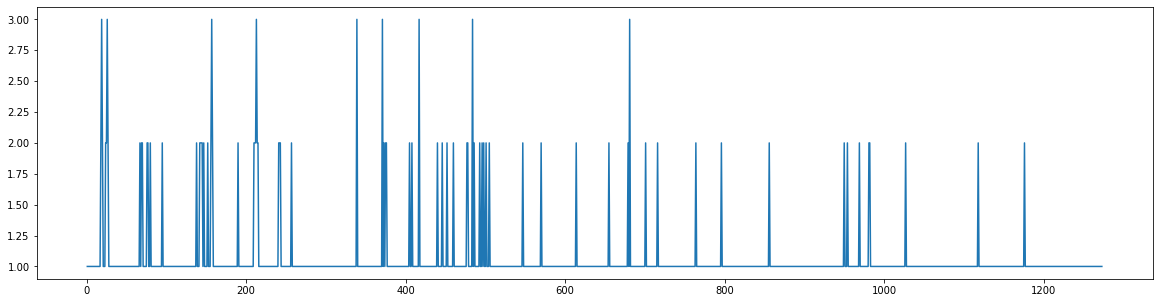

In [ ]:
muts_per_index = aa_count.groupby(aa_index).max()
import seaborn as sns

ax = sns.lineplot(x=muts_per_index.index.values, y=muts_per_index.values)
fig = ax.figure
fig.set_size_inches(20, 5)

In [ ]:
#it appears, the max mutation is 3
align_df[align_df.aa_index.isin(muts_per_index[muts_per_index == 3].index.values)]#most different mutations

,QRN,QRX,QUD,QWE,UFO,UOZ,UTM,YP(Ref),aa_index
18,T,T,R,T,T,I,I,T,19
25,P,S,P,P,P,-,-,P,26
156,F,F,-,F,F,F,L,F,157
214,V,V,V,V,P,G,G,V,213
340,G,G,G,G,D,D,H,G,339
372,S,S,S,S,L,F,F,S,371
418,N,T,K,K,N,N,N,K,417
485,K,K,E,E,A,A,A,E,484
682,P,P,R,H,H,H,H,P,681


## From the mutations in each sequence and the figure from Viralzone, let's determine which variant each sequence belongs to. 

In [ ]:
align_df[align_df.aa_index == 570]

,QRN,QRX,QUD,QWE,UFO,UOZ,UTM,YP(Ref),aa_index
571,A,A,A,D,A,A,A,A,570


A570D is seen in the Alpha variant and also seen in the QWE strain.

In [ ]:
align_df[align_df.aa_index == 215]

,QRN,QRX,QUD,QWE,UFO,UOZ,UTM,YP(Ref),aa_index
216,G,D,D,D,D,D,D,D,215


For QRN, we see D215G.
This is seen in Beta variant

In [ ]:
align_df[align_df.aa_index == 190]

,QRN,QRX,QUD,QWE,UFO,UOZ,UTM,YP(Ref),aa_index
189,R,S,R,R,R,R,R,R,190


For QRX, we see R190S. This is seen only in Gamma variant, therefore QRX is the gamma variant

In [ ]:
align_df[align_df.aa_index == 501]

,QRN,QRX,QUD,QWE,UFO,UOZ,UTM,YP(Ref),aa_index
502,Y,Y,N,Y,Y,Y,Y,N,501


Only variant QUD doesnt have the N 501Y mutation. This is only the case for Delta. Therefore, QUD is the Delta Variant

- Alpha- QWE
- Beta- QRN
- Gamma- QRX
- Delta - QUD